In [1]:
# config env
pkgs_path = "/bohr/pkgs-7x29/v5/pkgs"
llava_lib_path = "/bohr/libb-bg5b/v3/llava"
tsr_model_path = "microsoft/table-structure-recognition-v1.1-all"
model_path = "/bohr/llov-rplv/v2/llava-onevision-qwen2-7b-ov/"
cache_path = "/bohr/cach-rxl3/v1/cache"

# pkgs_path = "/personal/pkgs"
# llava_lib_path = "/personal/llava"
# model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
# cache_path = "/personal/cache"

!pip install {pkgs_path}/*
!cp {llava_lib_path} . -r

import os

# # 提交时可能不能联网，设置成离线模式防止联网失败报错
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HUGGINGFACE_HUB_CACHE"] = cache_path
os.environ["HF_HOME"] = cache_path
device = "cuda"

In [2]:
from llava.conversation import Conversation, SeparatorStyle
from llava.utils import disable_torch_init
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import json
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN
import torch

from PIL import ImageDraw, Image

import warnings

warnings.filterwarnings("ignore")

/opt/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "conv_mode": None,
    "sep": ",",
    "temperature": 0,
    "top_p": 1,
    "num_beams": 1,
    "max_new_tokens": 4
})()
torch.cuda.empty_cache()
disable_torch_init()

llava_model_args = {
        "multimodal": True,
    }
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config

tokenizer, model, image_processor, context_len = load_pretrained_model(
    args.model_path, args.model_base, args.model_name, device_map="auto",
    attn_implementation='eager',
    # load_8bit=True,
    # load_4bit=False,
     **llava_model_args
)

tsr_img_processor = AutoImageProcessor.from_pretrained(tsr_model_path)
tsr_img_processor.size['shortest_edge'] = image_processor.size[0]
tsr_model = TableTransformerForObjectDetection.from_pretrained(tsr_model_path)
label2id = tsr_model.config.label2id
label_row = label2id['table row']
label_col = label2id['table column']

Loaded LLaVA model: /bohr/llov-rplv/v2/llava-onevision-qwen2-7b-ov/
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.
Overwriting config with {'image_aspect_ratio': 'pad'}
Loading vision tower: google/siglip-so400m-patch14-384
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]
Model Class: LlavaQwenForCausalLM


In [4]:
if os.environ.get('DATA_PATH_B'):  # 提交时会选择隐藏的测试数据集路径（A+B榜），数据集的格式与A榜数据相同，但数目不同（5360张）
    base_dir = os.environ.get('DATA_PATH_B')
else:
    base_dir = '/bohr/form-recognition-train-b6y2/v4'  # 示例，把A榜测试数据集路径作为测试集路径，仅开发时挂载A榜数据用于debug   # 示例，把A榜测试数据集路径作为测试集路径，仅开发时挂载A榜数据用于debug

In [5]:
with open(os.path.join(base_dir, 'dataset.json'), 'r') as f:
    data = json.load(f)

In [6]:
from collections import defaultdict

l2i = defaultdict(lambda: -1)
for i, letter in enumerate('ABCDEFGH'):
    l2i[letter] = i
sub_list = ('Physics', 'Mathematics', 'ComputerScience', 'QuantitativeBiology', 'QuantitativeFinance',
            'Statistics', 'ElectricalEngineeringandSystemsScience', 'Economics', '')


def clean_out(image_path, out_list):
    try:
        rows = int(out_list[0])
    except:
        rows = -1
    try:
        cols = int(out_list[1])
    except:
        cols = -1
    sub_item = {
        "image_path": image_path,
        "category": sub_list[l2i[out_list[2]]],
        "cols": cols,
        "rows": rows,
        "answer": l2i[out_list[3]],
    }
    return sub_item

In [7]:
def tsr_process(raw_image):
    image = raw_image.copy()
    inputs = tsr_img_processor(images=image, return_tensors="pt")
    outputs = tsr_model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])  # (height, width) of each image in the batch
    results = tsr_img_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    draw = ImageDraw.Draw(image)
    rows = 0
    cols = 0
    for label, box in zip(results["labels"], results["boxes"]):
        label, box = label.item(), box.tolist()
        draw.rectangle(box, outline="red", width=1)

        if label == label_row:
            rows += 1
        elif label == label_col:
            cols += 1
    return image, rows, cols


def one_image(img_path, caption, qs_list):
    image = Image.open(img_path).convert("RGB")
    tsr_image, rows, cols = tsr_process(image)
    # print(rows, cols)
    image_sizes = [
        image.size,
        tsr_image.size
    ]
    images = [image, tsr_image]
    image_tensors = process_images(images, image_processor, model.config)
    image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]

    out_list = []
    with torch.inference_mode():
        conv = Conversation(
            system="""<|im_start|>system
            You are a helpful assistant. Provide only an option's letter or an integer for each question, without any additional explanation.""",
            roles=["<|im_start|>user", "<|im_start|>assistant"],
            version="qwen",
            messages=[
                ["<|im_start|>user",
                 f'{DEFAULT_IMAGE_TOKEN}\n The first image shows a raw table. {DEFAULT_IMAGE_TOKEN}\n The second image displays the same table with a red-bordered outline. The caption of the table is "{caption}".'],
                ["<|im_start|>assistant", "I have a general understanding of the information in this table."]
            ],
            offset=0,
            sep_style=SeparatorStyle.CHATML,
            sep="<|im_end|>",
        )
        for qs in qs_list:
            conv.append_message(conv.roles[0], qs)
            conv.append_message(conv.roles[1], None)
            prompt = conv.get_prompt()
            input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(
                0).cuda()

            output_ids = model.generate(
                input_ids,
                images=image_tensors,
                image_sizes=image_sizes,
                do_sample=True if args.temperature > 0 else False,
                temperature=args.temperature,
                top_p=args.top_p,
                num_beams=args.num_beams,
                max_new_tokens=args.max_new_tokens,
                use_cache=True,
            )
            outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
            conv.messages[-1][-1] = outputs
            out_list.append(outputs)
    return out_list

Based on the provided tables and caption, for the question: "What is the target error for Task1 using the NN policy with CODE algorithm?", select the most correct option from (A. 0.41, B. 0.79, C. 0.89, D. 0.01). Answer with the option's letter from the given choices directly.
['2', '6', 'C', 'A']
{'image_path': 'c4e88412-1402-49fa-80ff-f3b372644ac2.png', 'category': 'ComputerScience', 'cols': 6, 'rows': 2, 'answer': 0}


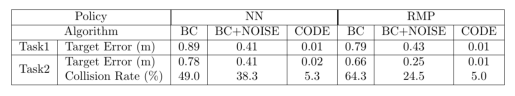

Based on the provided tables and caption, for the question: "What is the total number of unsolved cases (U) by solver "depqbf" across both \DYS and \ENC benchmarks?", select the most correct option from (A. 27., B. 22., C. 14, D. 4.). Answer with the option's letter from the given choices directly.
['10', '6', 'C', 'B']
{'image_path': 'ac1039e9-e60b-47c8-b9a6-43f51ca77a43.png', 'category': 'ComputerScience', 'cols': 6, 'rows': 10, 'answer': 1}


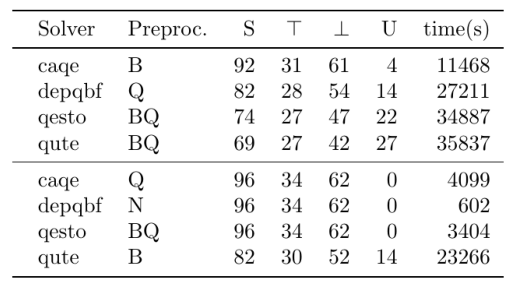

Based on the provided tables and caption, for the question: "What is the significance level of the Unemployment Rate in column (3)?", select the most correct option from (A. p<0.10, B. p<0.01, C. p>0.05, D. p<0.05). Answer with the option's letter from the given choices directly.
['12', '13', 'F', 'B']
{'image_path': 'e08001e9-598a-49f3-b0a2-3d7c0858765a.png', 'category': 'Statistics', 'cols': 13, 'rows': 12, 'answer': 1}


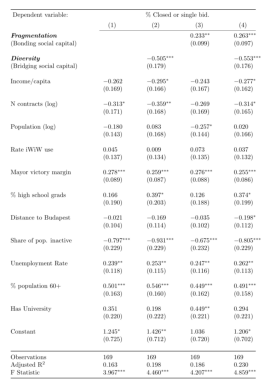

Based on the provided tables and caption, for the question: "What is the Max value for the DIMACS instance "san400\_0.7\_1" when $k$ equals 2?", select the most correct option from (A. 42, B. 40, C. 43, D. 41). Answer with the option's letter from the given choices directly.
['12', '6', 'C', 'A']
{'image_path': '989b38c3-992a-4662-b3b0-9c09d635381c.png', 'category': 'ComputerScience', 'cols': 6, 'rows': 12, 'answer': 0}


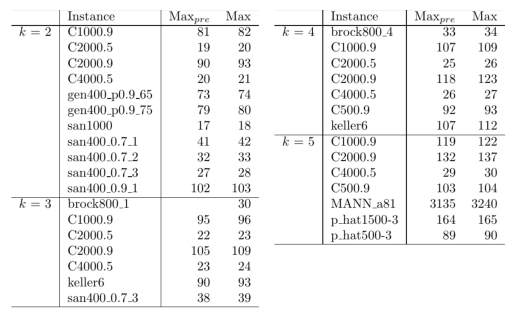

Based on the provided tables and caption, for the question: "What is the approximate value reported for GSPM (s = 1.0) when $\Delta t = T/250$?", select the most correct option from (A. 1.6055e-06, B. 2.7388e-07, C. 1.0740e-06, D. 3.2270e-07). Answer with the option's letter from the given choices directly.
['7', '6', 'F', 'C']
{'image_path': '1832a6f2-935c-435e-ac3e-75b70aa6f435.png', 'category': 'Statistics', 'cols': 6, 'rows': 7, 'answer': 2}


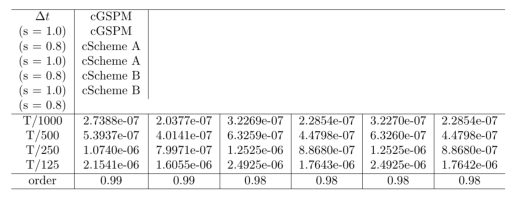

AVG 2.484092717400017


In [8]:
# submission = []
# device = "cuda"
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import time
# num = 5
# idx = 1500
# start = time.perf_counter()
# for item in data[idx: idx + num]:
#     image_path = os.path.join(base_dir, 'test_images', item["image_path"])
#     qs_list = [
#         f'Based on the second table, how many rows are in this table? Just answer an exact integer:',
#         f'Based on the second table, how many cols are in this table? Just answer an exact integer:',
#         f"""Based on the provided tables and caption, select the most relevant subject from (A. Physics, B. Mathematics, C. ComputerScience, D. QuantitativeBiology, E. QuantitativeFinance, F. Statistics, G. ElectricalEngineeringandSystemsScience, H. Economics). Answer with the option's letter from the given choices directly.""",
#         f"""Based on the provided tables and caption, for the question: "{item["question"]}", select the most correct option from (A. {item["options"][0]}, B. {item["options"][1]}, C. {item["options"][2]}, D. {item["options"][3]}). Answer with the option's letter from the given choices directly."""
#     ]
#     out_list = one_image(image_path,item["caption"], qs_list)
#     sub_item = clean_out(item["image_path"], out_list)
#     submission.append(sub_item)
#     print(qs_list[-1])
#     print(out_list)
#     print(sub_item)
#     img = mpimg.imread(image_path)

#     # 显示图片
#     plt.imshow(img)
#     plt.axis('off')  # 不显示坐标轴
#     plt.show()
# end = time.perf_counter()
# print("AVG", (end - start) / num)

In [9]:
submission = []

for item in data:
    image_path = os.path.join(base_dir, 'test_images', item["image_path"])
    qs_list = [
        f'Based on the second table, how many rows are in this table? Just answer an exact integer:',
        f'Based on the second table, how many cols are in this table? Just answer an exact integer:',
        f"""Based on the provided tables and caption, select the most relevant subject from (A. Physics, B. Mathematics, C. ComputerScience, D. QuantitativeBiology, E. QuantitativeFinance, F. Statistics, G. ElectricalEngineeringandSystemsScience, H. Economics). Answer with the option's letter from the given choices directly.""",
        f"""Based on the provided tables and caption, for the question: "{item["question"]}", select the most correct option from (A. {item["options"][0]}, B. {item["options"][1]}, C. {item["options"][2]}, D. {item["options"][3]}). Answer with the option's letter from the given choices directly."""
    ]
    out_list = one_image(image_path,item["caption"], qs_list)
    sub_item = clean_out(item["image_path"], out_list)
    submission.append(sub_item)

with open('submission.json', 'w') as f:
    json.dump(submission, f)